In [1]:
import phoebe
import numpy as np
logger = phoebe.logger(clevel='WARNING')

In [2]:
b = phoebe.default_binary()
b['requiv@primary'] = 1.35
b['requiv@secondary'] = 0.80
b['teff@primary'] = 6150
b['teff@secondary'] = 5680
b['q@orbit'] = 0.78
b['incl@orbit'] = 83.5

In [3]:
b.add_dataset('lc', times=phoebe.linspace(-0.6, 0.6, 241), passband='Johnson:V', dataset='ideal_lc', overwrite=True)

<ParameterSet: 80 parameters | contexts: constraint, figure, compute, dataset>

In [4]:
b.run_compute(irrad_method='none')

100%|██████████| 241/241 [00:03<00:00, 76.04it/s] 


<ParameterSet: 3 parameters | qualifiers: times, fluxes, comments>

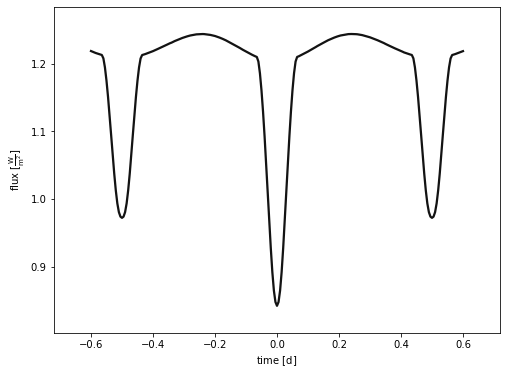

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [5]:
b.plot(show=True)

This is arguably quite a feature*ful* lightcurve, so let's see which parameters are well determined.

In [6]:
times = b['value@times@model@ideal_lc']
fluxes = b['value@fluxes@model@ideal_lc'] + np.random.normal(0, 0.01, size=241)
sigmas = np.ones_like(times)*0.01

In [7]:
b.add_dataset('lc', passband='Johnson:V', times=times, fluxes=fluxes, sigmas=sigmas, dataset='mock')

<ParameterSet: 47 parameters | contexts: constraint, figure, compute, dataset>

In [8]:
b.disable_dataset('ideal_lc')

<ParameterSet: 19 parameters | components: binary, secondary, primary>

In [9]:
b.run_compute(irrad_method='none')

Thu, 19 May 2022 15:29 BUNDLE       WARNING overwriting model: latest
100%|██████████| 241/241 [00:03<00:00, 77.88it/s] 


<ParameterSet: 3 parameters | qualifiers: times, fluxes, comments>

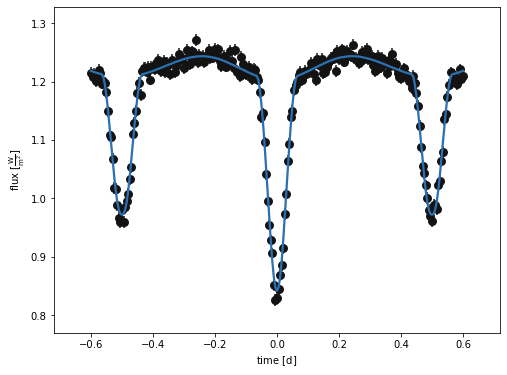

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [10]:
b.plot(show=True)

In [11]:
b.add_solver('optimizer.nelder_mead', solver='nms', maxfev=100, fatol=0.000241, overwrite=True)

Thu, 19 May 2022 15:29 BUNDLE       WARNING 'maxfev' not a recognized kwarg


<ParameterSet: 14 parameters | qualifiers: adaptive, xatol, maxiter, continue_from, comments, initial_values, expose_lnprobabilities, fit_parameters, priors, fatol, use_server, progress_every_niters, compute, priors_combine>

In [19]:
b['fit_parameters@nms'] = ['teff@primary', 'teff@secondary', 'pblum@primary@mock']

In [13]:
b.run_solver('nms', solution='adjust_teffs')

  0%|          | 166/1000000 [16:53<1695:57:56,  6.11s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_values, fitted_values, success, message, fitted_units, comments, adopt_parameters, adopt_distributions, niter, initial_values, fitted_twigs>

In [16]:
print(b['adjust_teffs'])

ParameterSet: 11 parameters
R  fitted_twigs@adjust_teffs@s...: ['teff@primary@star@component' 'teff@secondary@star@component'
 'pblum@primary@ideal_lc@lc@dataset' 'pblum@primary@mock@lc@dataset']
   adopt_parameters@adjust_tef...: ['teff@primary@star@component', 'teff@secondary@star@component', 'pblum@primary@ideal_lc@lc@dataset', 'pblum@primary@mock@lc@dataset']
   adopt_distributions@adjust_...: False
   adopt_values@adjust_teffs@s...: True
R   message@adjust_teffs@solution: Optimization terminated successfully.
R     niter@adjust_teffs@solution: 165
R   success@adjust_teffs@solution: True
R  initial_values@adjust_teffs...: [6150.0 5680.0 12.566370614359172 12.566370614359172]
R  fitted_values@adjust_teffs@...: [6245.820047625524 5742.706129814706 12.834374961237703 12.529753387953212]
R  fitted_units@adjust_teffs@s...: ['K' 'K' 'W' 'W']
   comments@adjust_teffs@solution: 


In [17]:
print(b['enabled'])

ParameterSet: 2 parameters
   enabled@ideal_lc@phoebe01@c...: False
    enabled@mock@phoebe01@compute: True


In [15]:
b.calculate_chi2()

261.4107590067423

NMS is demonstrably too slow, so we'll implement DC instead.

In [17]:
def run_dc(steps):
    obs = b['value@fluxes@mock@dataset']
    sigs = b['value@sigmas@mock@dataset']
    fit_params = b['value@fit_parameters@nms']
    orig_values = [b[f'value@{param}'] for param in fit_params]

    A = np.empty(shape=(len(obs), len(fit_params)))
    V = np.diag(1/sigs)

    b.run_compute(irrad_method='none', model='baseline', overwrite=True)
    xi = obs-b['value@fluxes@baseline@model']

    for k, param in enumerate(fit_params):
        if 'pblum' in param:
            A[:,k] = 1
            continue
        b[param] = orig_values[k] + steps[k]/2
        b.run_compute(irrad_method='none', model='upper', overwrite=True)
        b[param] = orig_values[k] - steps[k]/2
        b.run_compute(irrad_method='none', model='lower', overwrite=True)
        b[param] = orig_values[k]

        A[:,k] = (b['value@fluxes@upper']-b['value@fluxes@lower'])/steps[k]

    return np.linalg.lstsq(V@A, V@xi, rcond=None)

In [18]:

b['teff@secondary'] = 5880
b['fit_parameters@nms'] = ['teff@secondary', 'pblum@primary@mock', 'requiv@primary', 'requiv@secondary']
steps = [50, 0.01, 0.05, 0.05]
corrections = run_dc(steps)

100%|██████████| 241/241 [00:03<00:00, 77.31it/s] 


In [19]:
corrections

(array([-2.05223345e+02, -3.42616093e-03, -2.38053528e-03,  7.77009983e-03]),
 array([234.55338972]),
 4,
 array([1.94060745e+03, 2.62516845e+02, 1.10118093e+02, 6.41495617e-02]))

In [48]:
b['teff@primary']

<Parameter: teff=6200.0 K | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>